In [1]:
from avatar_sgg.notebooks.util import image_grid
from avatar_sgg.dataset.util import get_ade20k_split
from avatar_sgg.image_retrieval.baseline import vectorize_captions, compute_average_similarity, calculate_normalized_cosine_similarity
import torch
from operator import itemgetter
from sentence_transformers import SentenceTransformer

In [2]:
train, dev, test = get_ade20k_split()

current = dev
vectorizer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
stacked_vectors = vectorize_captions(current, vectorizer)
similarity = calculate_normalized_cosine_similarity(stacked_vectors)

number_entries = similarity.shape[0]
values, ranks = torch.topk(similarity, number_entries)
gold_recommendations = torch.arange(0, number_entries, dtype=ranks.dtype, device=ranks.device).unsqueeze(1)


Server Setup: config.yaml will be used


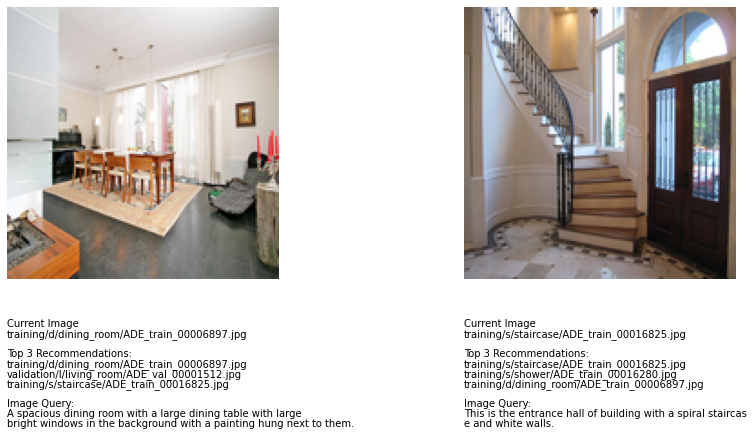

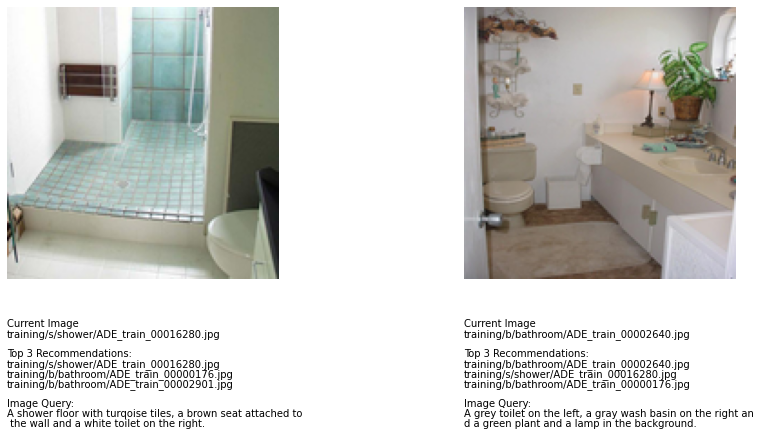

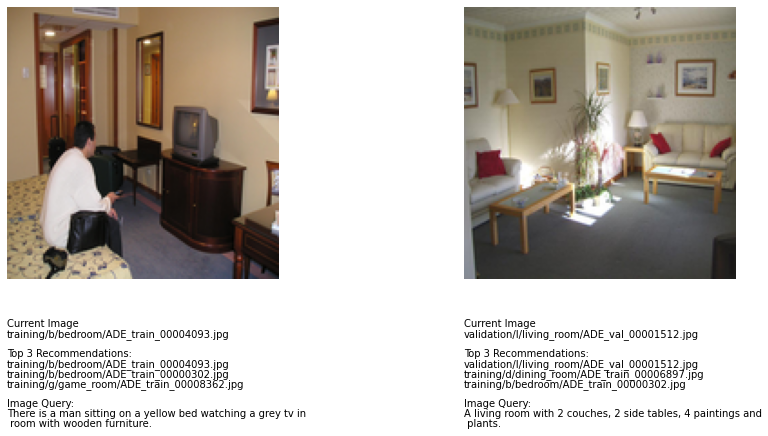

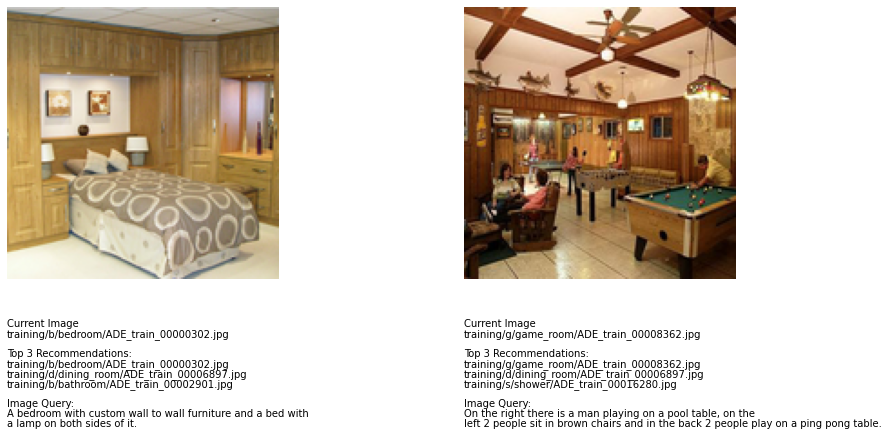

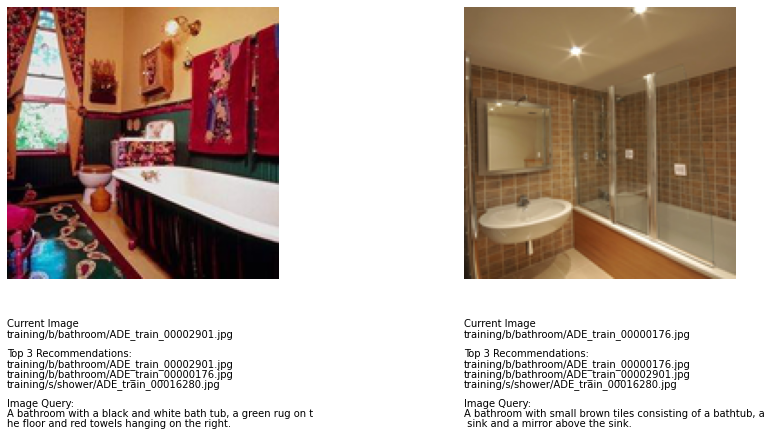

In [5]:
root = '/media/rafi/Samsung_T5/_DATASETS/ADE20K/images/'

IMAGES_TO_DISPLAY = len(current.keys())
COLUMNS = 2
CAPTION_THESHOLD = 60
idx_path_lookup = {i:k for i, k in enumerate(current.keys()) }
at_k = 3

all_annotations = []

for n, r in enumerate(ranks):
    
    current_captions = current[idx_path_lookup[n]]["caption"]
    
    idx = r[:at_k]
    description = [ "Current Image\n", idx_path_lookup[n].split(root)[1] , "\n",f"Top {at_k} Recommendations:\n"]
    recommended_images = itemgetter(*idx.tolist())(idx_path_lookup)
    recommendations = [i.split(root)[1] for i in recommended_images]
    description.extend(recommendations)
    description.extend(["\n", "Image Query:\n"])
    
    image_query = current_captions[1]

    if len(image_query) > CAPTION_THESHOLD:
        description.extend([image_query[: CAPTION_THESHOLD], image_query[CAPTION_THESHOLD:]])
    else:
        description.append(image_query)
    
    all_annotations.append(description)

img_paths = list(current.keys())

image_grid(img_paths, all_annotations, top=IMAGES_TO_DISPLAY, per_row=COLUMNS)